<a href="https://colab.research.google.com/github/harshmatkar/dcgan-anime-face-generator/blob/main/GCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Fri Jul 18 08:32:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!pip install matplotlib imageio tqdm

In [ ]:
import os
import torch
from torch import nn, optim
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
from google.colab import files
files.upload()  # upload kaggle.json when prompted

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"harshmatkar","key":"a5e9f68b9cb5ca380b2812fc9cf8ca81"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d splcher/animefacedataset
!unzip animefacedataset.zip -d anime_faces


Streaming output truncated to the last 5000 lines.
  inflating: anime_faces/images/62764_2019.jpg  
  inflating: anime_faces/images/62765_2019.jpg  
  inflating: anime_faces/images/62766_2019.jpg  
  inflating: anime_faces/images/62767_2019.jpg  
  inflating: anime_faces/images/62768_2019.jpg  
  inflating: anime_faces/images/62769_2019.jpg  
  inflating: anime_faces/images/6276_2003.jpg  
  inflating: anime_faces/images/62770_2019.jpg  
  inflating: anime_faces/images/62771_2019.jpg  
  inflating: anime_faces/images/62772_2019.jpg  
  inflating: anime_faces/images/62773_2019.jpg  
  inflating: anime_faces/images/62774_2019.jpg  
  inflating: anime_faces/images/62775_2019.jpg  
  inflating: anime_faces/images/62776_2019.jpg  
  inflating: anime_faces/images/62777_2019.jpg  
  inflating: anime_faces/images/62778_2019.jpg  
  inflating: anime_faces/images/62779_2019.jpg  
  inflating: anime_faces/images/6277_2003.jpg  
  inflating: anime_faces/images/62780_2019.jpg  
  inflating: anime_f

In [ ]:
!unzip -o animefacedataset.zip -d anime_faces

Streaming output truncated to the last 5000 lines.
  inflating: anime_faces/images/62764_2019.jpg  
  inflating: anime_faces/images/62765_2019.jpg  
  inflating: anime_faces/images/62766_2019.jpg  
  inflating: anime_faces/images/62767_2019.jpg  
  inflating: anime_faces/images/62768_2019.jpg  
  inflating: anime_faces/images/62769_2019.jpg  
  inflating: anime_faces/images/6276_2003.jpg  
  inflating: anime_faces/images/62770_2019.jpg  
  inflating: anime_faces/images/62771_2019.jpg  
  inflating: anime_faces/images/62772_2019.jpg  
  inflating: anime_faces/images/62773_2019.jpg  
  inflating: anime_faces/images/62774_2019.jpg  
  inflating: anime_faces/images/62775_2019.jpg  
  inflating: anime_faces/images/62776_2019.jpg  
  inflating: anime_faces/images/62777_2019.jpg  
  inflating: anime_faces/images/62778_2019.jpg  
  inflating: anime_faces/images/62779_2019.jpg  
  inflating: anime_faces/images/6277_2003.jpg  
  inflating: anime_faces/images/62780_2019.jpg  
  inflating: anime_f

In [ ]:
!ls anime_faces

images


In [ ]:
!ls anime_faces/images | wc -l

63565


In [ ]:
import glob

# Match png/jpg/jpeg recursively
image_patterns = ["anime_faces/**/*.[pP][nN][gG]", "anime_faces/**/*.[jJ][pP][gG]", "anime_faces/**/*.[jJ][pP][eE][gG]"]

all_imgs = []
for pattern in image_patterns:
    all_imgs.extend(glob.glob(pattern, recursive=True))

print(f"Found {len(all_imgs)} images")

# Try to show one image
if all_imgs:
    from PIL import Image
    img = Image.open(all_imgs[0])
    img.show()


Found 63565 images


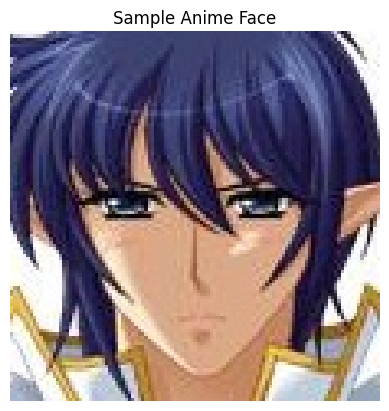

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

img = Image.open(all_imgs[0])

plt.imshow(img)
plt.axis("off")
plt.title("Sample Anime Face")
plt.show()

In [ ]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),  # Converts to [0, 1]
    transforms.Normalize([0.5]*3, [0.5]*3)  # Normalizes to [-1, 1]
])

In [ ]:
!mkdir anime_faces/processed
!mv anime_faces/images anime_faces/processed/anime

In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

dataset = ImageFolder(root="anime_faces/processed", transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)

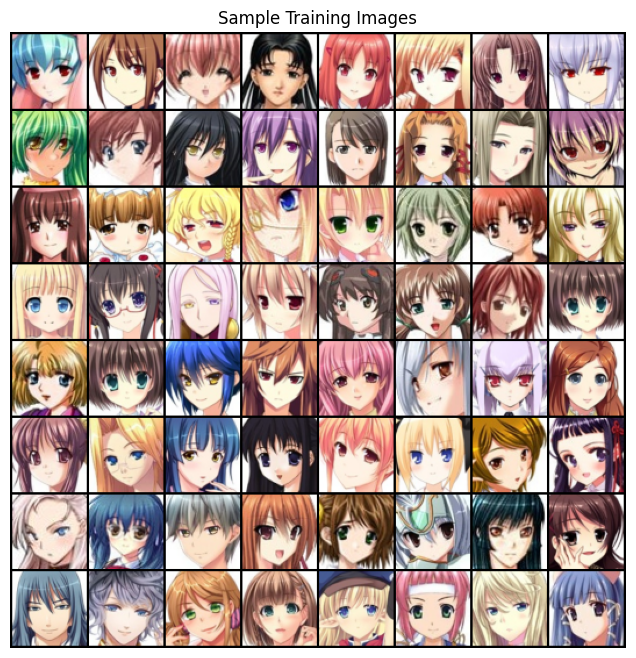

In [ ]:
import torchvision.utils as vutils

# Get one batch
dataiter = iter(dataloader)
images, _ = next(dataiter)

# Denormalize for visualization
images = images[:64] * 0.5 + 0.5  # Convert from [-1,1] to [0,1]

# Plot
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Sample Training Images")
plt.imshow(np.transpose(vutils.make_grid(images, padding=2, normalize=False), (1,2,0)))
plt.show()


In [ ]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, z_dim=100, img_channels=3, features_g=64):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            # Input: N x z_dim x 1 x 1
            self._block(z_dim, features_g * 8, 4, 1, 0),  # 4x4
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # 8x8
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # 16x16
            self._block(features_g * 2, features_g, 4, 2, 1),      # 32x32
            nn.ConvTranspose2d(features_g, img_channels, 4, 2, 1), # 64x64
            nn.Tanh()  # Output range [-1, 1]
        )

    def _block(self, in_c, out_c, k, s, p):
        return nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, kernel_size=k, stride=s, padding=p, bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.gen(x)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, img_channels=3, features_d=64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # Input: N x 3 x 64 x 64
            nn.Conv2d(img_channels, features_d, 4, 2, 1),  # 32x32
            nn.LeakyReLU(0.2, inplace=True),

            self._block(features_d, features_d * 2, 4, 2, 1),  # 16x16
            self._block(features_d * 2, features_d * 4, 4, 2, 1),  # 8x8
            self._block(features_d * 4, features_d * 8, 4, 2, 1),  # 4x4

            nn.Conv2d(features_d * 8, 1, 4, 1, 0),  # 1x1
            nn.Sigmoid()
        )

    def _block(self, in_c, out_c, k, s, p):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=k, stride=s, padding=p, bias=False),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        return self.disc(x)


In [ ]:
z_dim = 100
gen = Generator(z_dim=z_dim).to(device)
disc = Discriminator().to(device)

print("Generator Parameters:", sum(p.numel() for p in gen.parameters()))
print("Discriminator Parameters:", sum(p.numel() for p in disc.parameters()))

Generator Parameters: 3576707
Discriminator Parameters: 2765633


In [ ]:
import torch.optim as optim

# Loss: Binary Cross Entropy
criterion = nn.BCELoss()

# Create fixed noise for sampling progress images
fixed_noise = torch.randn(64, z_dim, 1, 1, device=device)

# Optimizers (DCGAN recommends betas=(0.5, 0.999))
lr = 2e-4
optimizer_gen = optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_disc = optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))


In [ ]:
import torchvision.utils as vutils
from tqdm import tqdm

epochs = 50  # Reduce to 25 if time is limited

for epoch in range(epochs):
    loop = tqdm(dataloader, leave=True)
    for batch_idx, (real, _) in enumerate(loop):
        real = real.to(device)
        noise = torch.randn(real.size(0), z_dim, 1, 1, device=device)
        fake = gen(noise)

        ### Train Discriminator: maximize log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real).view(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))

        disc_fake = disc(fake.detach()).view(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))

        loss_disc = (loss_disc_real + loss_disc_fake) / 2

        disc.zero_grad()
        loss_disc.backward()
        optimizer_disc.step()

        ### Train Generator: maximize log(D(G(z)))
        output = disc(fake).view(-1)
        loss_gen = criterion(output, torch.ones_like(output))

        gen.zero_grad()
        loss_gen.backward()
        optimizer_gen.step()

        # Logging
        loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
        loop.set_postfix(D_loss=loss_disc.item(), G_loss=loss_gen.item())

    # Save sample output every few epochs
    if (epoch + 1) % 5 == 0:
        with torch.no_grad():
            fake_samples = gen(fixed_noise).detach().cpu()
        vutils.save_image(fake_samples * 0.5 + 0.5, f"anime_gen_epoch_{epoch+1}.png", nrow=8)


Epoch [50/50]: 100%|██████████| 497/497 [01:21<00:00,  6.08it/s, D_loss=0.0124, G_loss=6.63]


In [ ]:
!mkdir -p /content/drive/MyDrive/dcgan_anime

In [ ]:
!mkdir -p /content/drive/MyDrive/dcgan_anime

In [ ]:
torch.save(gen.state_dict(), "/content/drive/MyDrive/dcgan_anime/generator.pth")
torch.save(disc.state_dict(), "/content/drive/MyDrive/dcgan_anime/discriminator.pth")

In [ ]:
# Generator class must be defined exactly as in training
gen = Generator(z_dim=100).to(device)
gen.load_state_dict(torch.load("/content/drive/MyDrive/dcgan_anime/generator.pth"))
gen.eval()  # Set to evaluation mode

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

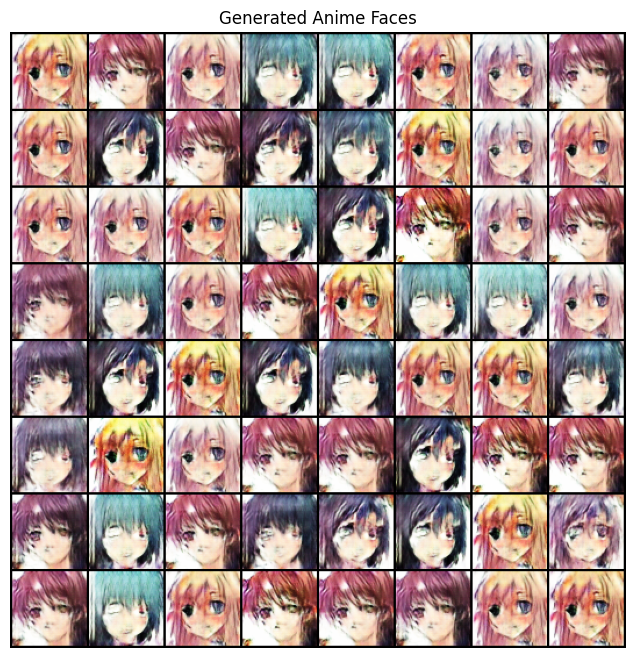

In [ ]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Generate random noise vector
z = torch.randn(64, 100, 1, 1).to(device)

# Generate images using trained generator
with torch.no_grad():
    fake_images = gen(z)

# Convert to grid and show
grid = vutils.make_grid(fake_images.detach().cpu(), normalize=True, nrow=8)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Generated Anime Faces")
plt.imshow(grid.permute(1, 2, 0))
plt.show()

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!zip -r dcgan_anime.zip /content/drive/MyDrive/dcgan_anime

  adding: content/drive/MyDrive/dcgan_anime/ (stored 0%)
  adding: content/drive/MyDrive/dcgan_anime/anime_gen_epoch_5.png (deflated 0%)
  adding: content/drive/MyDrive/dcgan_anime/anime_gen_epoch_10.png (deflated 0%)
  adding: content/drive/MyDrive/dcgan_anime/anime_gen_epoch_15.png (deflated 0%)
  adding: content/drive/MyDrive/dcgan_anime/anime_gen_epoch_20.png (deflated 0%)
  adding: content/drive/MyDrive/dcgan_anime/anime_gen_epoch_25.png (deflated 0%)
  adding: content/drive/MyDrive/dcgan_anime/anime_gen_epoch_30.png (deflated 0%)
  adding: content/drive/MyDrive/dcgan_anime/anime_gen_epoch_35.png (deflated 0%)
  adding: content/drive/MyDrive/dcgan_anime/anime_gen_epoch_40.png (deflated 0%)
  adding: content/drive/MyDrive/dcgan_anime/anime_gen_epoch_45.png (deflated 0%)
  adding: content/drive/MyDrive/dcgan_anime/anime_gen_epoch_50.png (deflated 0%)
  adding: content/drive/MyDrive/dcgan_anime/generator.pth (deflated 7%)
  adding: content/drive/MyDrive/dcgan_anime/discriminator.pth 